## CSC 580 AI II (Winter 2026) **HW\#4 Atari Pong**
### **Pong_eval.ipynb** -- Run the trained model (using the greedy strategy).

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Mounted at /content/drive


In [2]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive/CSC580_Winter2026/Atari_Pong'
os.chdir(thisdir)

# Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive/CSC580_Winter2026/Atari_Pong


## Install relevant libraries

In [3]:
%pip install -r requirements.txt

In [4]:
import dqn_core # dqn_core.py
from dqn_core import AtariPreprocess, FrameStack, PongActionReducer, ReplayBuffer, DQN, make_env
import gymnasium as gym
import numpy as np
import random
import pickle

## Create an ale  (for display)

In [5]:
from ale_py import ALEInterface
ale = ALEInterface()

## 1. Load the pretrained Q-net weights

Assume the weight file is called "q_net_xxxk.pt", and it is found under the folder "checkpoints".

In [6]:
import torch # define GPU access
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# folder and filename for pretrained weights
checkpoint_dir = "checkpoints"
steps = "_700k"
weights_file = f"q_net{steps}.pt"

# first create an environment (where 'n_actions' is defined)
env = make_env() # default env (no visualization)
n_actions = env.action_space.n
print(f"✅ Number of actions: {n_actions}")

# then create a DQN (prediction) net
q_net = DQN(n_actions)

# load the pretrained weights on the network (cpu will do for evaluation)
weights = torch.load(f"{checkpoint_dir}/{weights_file}", map_location="cpu")
q_net.load_state_dict(weights)

# Define optimizer here, after q_net is instantiated
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4)

✅ Number of actions: 4


## Run a live Pong animation to ensure things are loaded correctly.

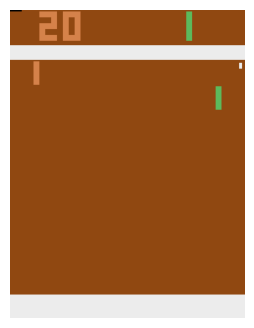

Total reward: -20.0


In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import time

env = make_env(render_mode="rgb_array") # for visual rendering

obs, info = env.reset()
obs, _, _, _, _ = env.step(1)  # FIRE to start the game

# set up the visualization variables (fig, img, ax)
fig, ax = plt.subplots(figsize=(4, 4))
img = ax.imshow(env.render())
ax.axis("off")

display_handle = display(fig, display_id=True) # set up display_handle

# (*) start an episode (until either player reaches 21 points)
# actions were chosen by the greedy strategy, selecting the action with the
# largest value produced on the output layer of the model (q_net).
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        # tranform obs (4, 84, 84) to a batch (of one instance)
        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

        # (*) select action with the highest Q-value for the current state.
        action = q_net(state).argmax(1).item()
        # q_net(state) returns model output, which is a tensor containing
        # values of the actions, e.g. 'tensor([[ 1.2, -0.4,  0.7,  3.5]])',
        # where the inner list is the average rewards of the actions.
        # Then .argmax(1) returns 'tensor([3])', then by .item(), we get 3,
        # the action number of the 'best' action.

    # take the action and receive info from the environment
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    # visualization
    img.set_data(env.render())
    display_handle.update(fig)

    time.sleep(0.03)

plt.close(fig)
env.close()

print("Total reward:", total_reward)


## Add the 'Ball Hit' counts.  
We detect a hit through bright spots (call) in the input image.

In [7]:
import cv2

def detect_ball(obs):
    """
    obs: (84, 84) uint8 grayscale frame
    returns (x, y) or None
    """
    # Defensive: ensure uint8 (in case the value was 0-1 normalized already)
    if obs.max() <= 1.0:
        obs = (obs * 255).astype(np.uint8)

    # Threshold bright pixels (200-255)
    _, thresh = cv2.threshold(obs, 200, 255, cv2.THRESH_BINARY)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        thresh, connectivity=8
    )

    # Skip background (label 0)
    candidates = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        cx, cy = centroids[i]

        # Ball is small (paddle is tall and large)
        if 2 <= area <= 50:
            candidates.append((area, cx, cy))

    if not candidates:
        return None

    # Choose smallest bright object (ball)
    _, x, y = min(candidates, key=lambda x: x[0])
    return int(x), int(y)


In [8]:
def count_paddle_hits(env, model):
    """
    Run one episode (up to max_steps though) and counts the number of times
    the user's paddle hit the ball.
    """
    obs, info = env.reset()

    # FIRE to start Pong
    obs, _, _, _, _ = env.step(1)

    prev_x = None
    prev_dx = None
    hit_count = 0
    done = False

    while not done:
        with torch.no_grad():
            # tranform obs (4, 84, 84) to a batch (of one instance)
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0) # (1, 4, 84, 84)

            # (*) select action with the highest Q-value for the current state.
            action = model(state).argmax(1).item()

        # take the selected action
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        #
        ball = detect_ball(obs[-1]) # find the ball in the last frame
        if ball is None:
            continue

        x, y = ball  # center coordinate of the ball
        if prev_x is not None:
            dx = x - prev_x  # horizontal displacement of the ball between frames.
                             # dx > 0 -- ball moving right, dx < 0 -- ball moving left

            # RIGHT paddle hit detection
            if prev_dx is not None:  # previous velocity estimate
                # Detect right-paddle hit via velocity reversal.
                # ball previously moving right, now moving left (and the x-position)
                # is close to the right edge of the screen (though 40 <= x <= 65).
                if prev_dx > 0 and dx < 0 and 40 <= x <= 65:
                    # user paddle hit the ball!!!
                    hit_count += 1

            prev_dx = dx
        prev_x = x

    return hit_count

## Evaluation run

One episode (deterministic) which prints the performance statistics (including hit_count).

In [9]:
env = make_env() # no visualization this time

# Call count_paddle_hits without the extra argument
hit_count = count_paddle_hits(env, q_net)

print(f"Hit_count = {hit_count}")
env.close()

Hit_count = 9
